In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [151]:
class GMM():
    def __init__(self, n_components, data):
        self.num_data = data.shape[0]
        self.dimension = data.shape[1]
        self.data = data
        self.components = n_components
        self.means = self.initialize_means()
        self.covariances = self.initialize_variances()
        self.lambdas = self.initialize_lambdas()
        
#         self.gammas = self.initialize_gammas()
#         self.means = self.calculate_means()
#         self.covariances = self.calculate_variances()
#         self.lambdas = self.calculate_lambdas()
    
    
    def initialize_means(self): 
        random_choice = np.random.choice(self.num_data, self.components, replace = False)
        means_ = self.data[random_choice]
        return means_
        
    def initialize_variances(self):
        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            covariances_[i] = np.cov(self.data, rowvar = False)
        return covariances_    
    
    def initialize_lambdas(self):
        return np.ones([self.components]) / float(self.components)
        
        
    def initialize_gammas(self):
        """Initializes gammas to random values maintaining their sum = 1 for each component"""
        gammas_ = np.random.rand(self.components, self.num_data)
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
        
    def calculate_means(self):
        """Calculates the means based on the current values of gammas"""
#         print(self.num_data, self.components, self.dimension)
        means_ = np.zeros((self.components, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                means_[i] += self.gammas[i][j] * self.data[j] / self.gammas[i].sum()
        return means_
        
    def calculate_variances(self):
        """Calculates the covariances based on the current values of gammas"""

        covariances_ = np.zeros((self.components, self.dimension, self.dimension))
        for i in range(self.components):
            for j in range(self.num_data):
                covariances_[i] += self.gammas[i][j] * np.dot((self.data[j] - self.means[i]).reshape(-1, 1), (self.data[j] - self.means[i]).reshape(-1, 1).T) / self.gammas[i].sum()
        return covariances_
    
    def calculate_lambdas(self):
        """Updates lambdas based on the values of gamma"""
        return self.gammas.sum(1)/self.gammas.sum()
    
    def calculate_gammas(self):
        """Updates gammas based on the values of the means, covariances and lambdas"""
        gammas_ = np.zeros((self.components, self.num_data))
        for i in range(self.components):
            for j in range(self.num_data):
                gammas_[i, j] = self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        gammas_ = gammas_ / gammas_.sum(0)
        return gammas_
    
    def calculate_likelihood(self):
        """Calculates the likelihood of data given parameters. We need to stop EM when likelihood saturates"""
        prb = np.zeros((self.num_data))
        for j in range(self.num_data):
            for i in range(self.components):
                prb[j] += self.lambdas[i] * self.gaussian_probability(self.data[j], self.means[i], self.covariances[i])
        likelihood_ = np.sum(np.log(prb))
#         print("Likelihood {}".format(likelihood_))
        return likelihood_
    
    def gaussian_probability(self, x_, mu_, sigma_):
        """Given the datapoint, mean for the component and the variance matrix of the component, calculates the probability"""
        x_ = x_.reshape(-1, 1)
        mu_ = mu_.reshape(-1, 1)

        prob_ = (1. / (np.power(2 * np.pi, self.dimension / 2.) * np.power(np.linalg.det(sigma_), 0.5))) * np.exp(- 0.5 * np.dot((x_ - mu_).T, np.dot(np.linalg.inv(sigma_), (x_ - mu_))))
        prob_ = float(prob_.reshape(1))
#         print(prob_)
        return prob_

    def EM(self, max_iter):
        likelihood_list = []
        for i in range(max_iter):
            self.gammas = self.calculate_gammas() # E STEP
            self.means = self.calculate_means() # M STEP
            self.covariances = self.calculate_variances() # M STEP
            self.lambdas = self.calculate_lambdas() # M STEP
            likelihood_list.append(self.calculate_likelihood()) #CALCULATE LIKELIHOOD
            if i % (max_iter / 20) == 0:
                print("Iteration {}, Log Likelihood {}".format(i, likelihood_list[-1]))
            if len(likelihood_list) > 10 and likelihood_list[-3] == likelihood_list[-1]:
                print("Converged")
                break
        return likelihood_list

### Data Preparation and Initialization

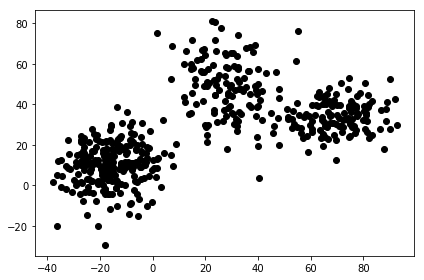

In [152]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        # pick a cluster id and create data from this cluster
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data


# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [30, 50],
    [-15, 10],
    [70, 35]
])

init_covariances = np.array([
    [[128.5, 0.], [0, 232.5]],
    [[75.92, 6.38], [6.38, 102.91]],
    [[105.5, 20.2], [20.2, 55.5]]
])

init_weights = [.25, .5, .25]

# generate data
# np.random.seed(4)
X = generate_data(500, init_means, init_covariances, init_weights)

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()
plt.show()

### Initializing Model on the Data

In [153]:
mod = GMM(3, X)

### Initial Parameters of the model

In [154]:
mod.covariances

array([[[ 1384.44189089,   434.96446612],
        [  434.96446612,   397.93104233]],

       [[ 1384.44189089,   434.96446612],
        [  434.96446612,   397.93104233]],

       [[ 1384.44189089,   434.96446612],
        [  434.96446612,   397.93104233]]])

In [155]:
mod.means

array([[ 67.05184227,  41.45167392],
       [ 56.25525409,  28.48808002],
       [ 30.70357789,  30.34266253]])

In [156]:
mod.lambdas

array([ 0.33333333,  0.33333333,  0.33333333])

### Running EM on the GMM

Log Likelihoods in every iteration are printed

In [157]:
likelihoods = mod.EM(100)

Iteration 0, Log Likelihood -4584.39078328
Iteration 5, Log Likelihood -4421.27833831
Iteration 10, Log Likelihood -4393.39870666
Iteration 15, Log Likelihood -4309.03344175
Iteration 20, Log Likelihood -4300.36732441
Iteration 25, Log Likelihood -4278.06756062
Iteration 30, Log Likelihood -4244.76000087
Iteration 35, Log Likelihood -4244.13303982
Iteration 40, Log Likelihood -4244.12786008
Iteration 45, Log Likelihood -4244.12782265
Iteration 50, Log Likelihood -4244.12782238
Iteration 55, Log Likelihood -4244.12782238
Iteration 60, Log Likelihood -4244.12782238
Converged


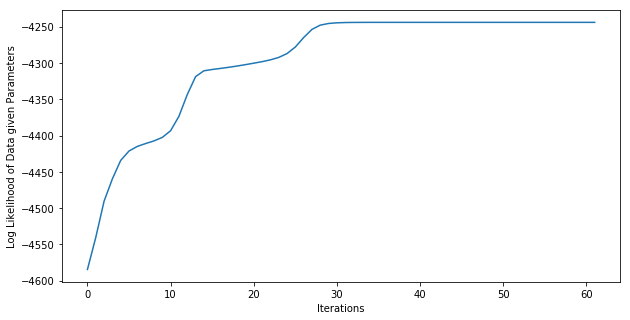

In [162]:
plt.figure(figsize=(10, 5))
plt.plot(likelihoods)
plt.ylabel("Log Likelihood of Data given Parameters")
plt.xlabel("Iterations")
plt.show()

### Model parameters after EM

In [141]:
mod.covariances

array([[[  74.69644946,   10.84630799],
        [  10.84630799,  102.58828972]],

       [[ 129.70081815,  -15.95797794],
        [ -15.95797794,  253.64681961]],

       [[ 105.96707115,   17.77566439],
        [  17.77566439,   54.66242786]]])

In [142]:
mod.lambdas

array([ 0.52605139,  0.2380214 ,  0.2359272 ])

In [143]:
mod.means

array([[-15.44909843,   9.87682116],
       [ 32.29525785,  50.68484079],
       [ 67.9631562 ,  35.21385148]])